## Getting started

In [1]:
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict, Tuple
import pandas as pd
import shutil
import os
import random

try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

try:
    from torchinfo import summary
except:
    print("[INFO] Installing torchinfo .")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from modular import engine, utils
    from modular.assist import set_seeds, plot_loss_curves
except:
    print("[INFO] Downloading from GitHub.")
    !git clone https://github.com/amunipelumi/foodvision-mini
    !mv foodvision-mini/modular .
    !rm -rf foodvision-mini
    from modular import engine, utils
    from modular.assist import set_seeds, plot_loss_curves

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 11.0 M

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
def create_model(num_classes:int=101, seed:int=13):

  """Creates an EfficientNetB2 feature extractor model and transforms.

  Args:
      num_classes (int, optional): number of classes in the classifier head.
          Defaults to 3.
      seed (int, optional): random seed value. Defaults to 13.

  Returns:
      model (torch.nn.Module): EffNetB2 feature extractor model.
      transforms (torchvision.transforms): EffNetB2 image transforms.
  """

  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  auto_transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes)
  )

  return model, auto_transforms

model_101, auto_transforms = create_model(101)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:01<00:00, 21.0MB/s]


In [4]:
manual_transforms = transforms.Compose([
    transforms.TrivialAugmentWide(),
    auto_transforms
])

In [5]:
print(f"Training transforms:\n{manual_transforms}\n")
print(f"Testing transforms:\n{auto_transforms}")

Training transforms:
Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

Testing transforms:
ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [6]:
summary(model_101,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## Getting data

In [7]:
data_dir = Path("data")

train_data = datasets.Food101(root=data_dir,
                              split="train",
                              transform=manual_transforms,
                              download=True)

test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=auto_transforms,
                             download=True)

len(train_data), len(test_data), len(train_data.classes)

100%|██████████| 4996278331/4996278331 [04:47<00:00, 17394528.07it/s]


Extracting data/food-101.tar.gz to data


(75750, 25250, 101)

In [8]:
train_data[0]

(tensor([[[-1.9980, -1.9467, -1.9638,  ..., -0.6452, -0.6794, -0.5253],
          [-1.9980, -1.9638, -1.9809,  ..., -0.4568, -0.5082, -0.4739],
          [-2.0152, -1.9809, -1.9980,  ..., -0.3883, -0.4226, -0.4397],
          ...,
          [ 0.5022,  0.4851,  0.4337,  ...,  0.3481,  0.3481,  0.3994],
          [ 0.4851,  0.4508,  0.3823,  ...,  0.4508,  0.4166,  0.5022],
          [ 0.4337,  0.3481,  0.2967,  ...,  0.5193,  0.4508,  0.5022]],
 
         [[-1.8431, -1.7906, -1.8081,  ..., -1.5280, -1.5805, -1.4755],
          [-1.8431, -1.8081, -1.8256,  ..., -1.3529, -1.4230, -1.4055],
          [-1.8606, -1.8256, -1.8431,  ..., -1.3004, -1.3880, -1.4230],
          ...,
          [-0.6877, -0.7052, -0.7577,  ...,  0.2927,  0.3277,  0.4153],
          [-0.7052, -0.7402, -0.8102,  ...,  0.3803,  0.3978,  0.5203],
          [-0.7577, -0.8452, -0.8978,  ...,  0.4503,  0.4503,  0.5203]],
 
         [[-1.6302, -1.5779, -1.5953,  ..., -1.6127, -1.6999, -1.6127],
          [-1.6302, -1.5953,

In [9]:
class_names = train_data.classes
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [10]:
BATCH_SIZE = 32
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78ba64ef2380>,
 <torch.utils.data.dataloader.DataLoader at 0x78ba64ef10c0>)

## Training model

In [ ]:
optimizer = torch.optim.Adam(params=model_101.parameters(), lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

set_seeds(13)
model_101_results = engine.train(model=model_101,
                                 train_dataloader=train_dataloader,
                                 test_dataloader=test_dataloader,
                                 optimizer=optimizer,
                                 loss_fn=loss_fn,
                                 epochs=5,
                                 device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.9866 | train_acc: 0.4064 | test_loss: 2.1894 | test_acc: 0.6083
Epoch: 2 | train_loss: 2.6545 | train_acc: 0.4806 | test_loss: 2.1102 | test_acc: 0.6275
Epoch: 3 | train_loss: 2.6109 | train_acc: 0.4908 | test_loss: 2.0716 | test_acc: 0.6387
Epoch: 4 | train_loss: 2.6009 | train_acc: 0.4979 | test_loss: 2.0555 | test_acc: 0.6450
Epoch: 5 | train_loss: 2.5991 | train_acc: 0.4975 | test_loss: 2.0506 | test_acc: 0.6447


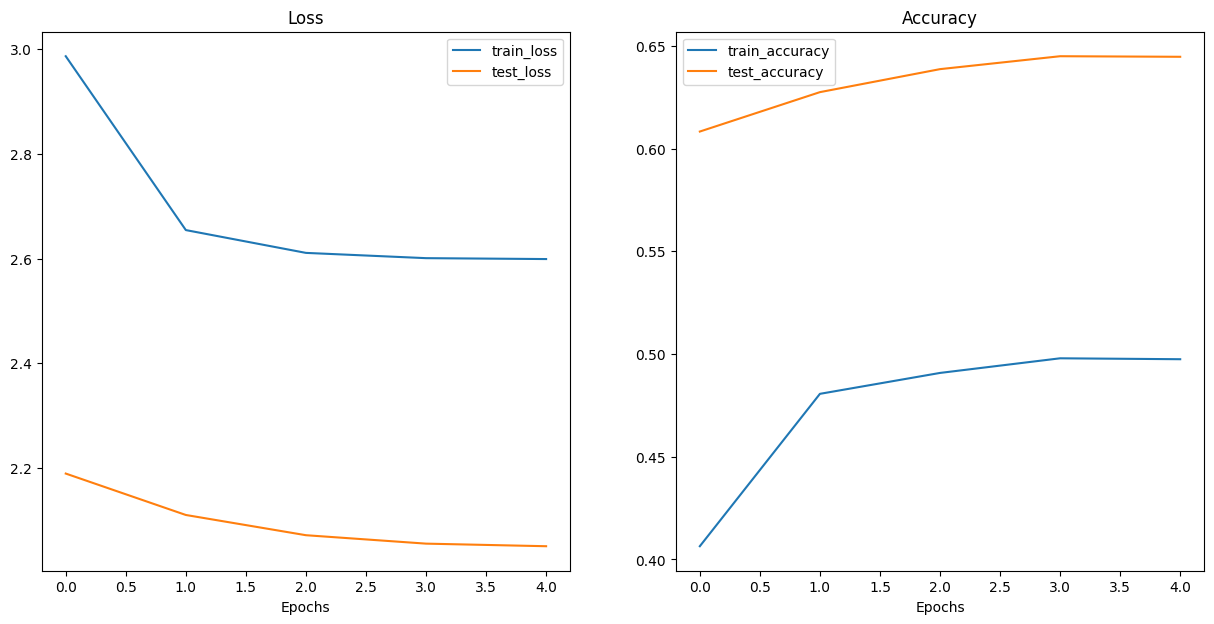

In [ ]:
plot_loss_curves(model_101_results)

## Save model

In [ ]:
utils.save_model(model=model_101,
                 target_dir="models",
                 model_name="effnetb2_feature_extractor_food101.pth")

[INFO] Saving model to: models/effnetb2_feature_extractor_food101.pth


In [ ]:
utils.save_model(model=model_101,
                 target_dir="drive/MyDrive/Colab Notebooks/PyTorch/Models/",
                 model_name="effnetb2_feature_extractor_food101.pth")

[INFO] Saving model to: drive/MyDrive/Colab Notebooks/PyTorch/Models/effnetb2_feature_extractor_food101.pth


In [11]:
loaded_model, transforms = create_model(num_classes=101)
loaded_model.load_state_dict(torch.load("drive/MyDrive/Colab Notebooks/PyTorch/Models/effnetb2_feature_extractor_food101.pth"))

<All keys matched successfully>

In [12]:
model_size = Path("drive/MyDrive/Colab Notebooks/PyTorch/Models/effnetb2_feature_extractor_food101.pth").stat().st_size // (1024*1024)
print(f"Model size: {model_size} MB")

Model size: 30 MB


In [13]:
total_params = sum(torch.numel(param) for param in loaded_model.parameters())
total_params

7843303

In [ ]:
stats = {"test_loss": round(model_101_results["test_loss"][-1], 2),
          "test_acc": round(model_101_results["test_acc"][-1], 2),
          "number_of_parameters": total_params,
          "model_size (MB)": model_size}
stats

{'test_loss': 2.05,
 'test_acc': 0.64,
 'number_of_parameters': 7843303,
 'model_size (MB)': 30}

## Predicting with model

In [29]:
def pred_and_store(paths: List[Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

  pred_list = []

  for path in tqdm(paths):

    pred_dict = {}

    pred_dict["image_path"] = path
    pred_dict["class_name"] = path.parent.stem

    start_time = timer()

    img = Image.open(path)

    transformed_image = transform(img).unsqueeze(0).to(device)

    model.to(device)
    model.eval()

    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)

      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict["pred_class"] = class_names[pred_label.cpu()]

      end_time = timer()
      pred_dict["time_for_pred (s)"] = round(end_time-start_time, 4)

    pred_dict["correct"] = pred_dict["class_name"] == pred_dict["pred_class"]

    pred_list.append(pred_dict)

  return pred_list

In [21]:
def pred_and_plot(paths: List[Path],
                  model: torch.nn.Module,
                  transform: torchvision.transforms,
                  class_names: List[str],
                  num: int = 3,
                  device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

  test_samples = []
  test_labels = []
  predicted_label = []

  for sample in random.sample(test_data_paths, k=num):
    test_samples.append(sample)
    test_labels.append(sample.parent.stem)

  for path in test_samples:
    img = Image.open(path)
    transformed_image = transform(img).unsqueeze(0).to(device)
    model.to(device)
    model.eval()

    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      predicted_label.append(pred_label)

  plt.figure(figsize=(10, 10))
  nrows = 3
  ncols = 1
  for i, sample in enumerate(test_samples):

    plt.subplot(nrows, ncols, i+1)
    img = Image.open(sample)
    plt.imshow(img)

    guessed_label = str(class_names[predicted_label[i]]).title().replace("_", " ")

    truth_label = test_labels[i].title().replace("_", " ")

    title_text = f"Prediction: {guessed_label} | Truth: {truth_label}"

    if guessed_label == truth_label:
      plt.title(title_text, fontsize=10, c="g")
    else:
      plt.title(title_text, fontsize=10, c="r")

    plt.axis('off');

In [22]:
print(f"[INFO] Finding all filepaths ending with '.jpg'")
test_data_paths = list(Path("data/food-101/images/").glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg'


[PosixPath('data/food-101/images/crab_cakes/20566.jpg'),
 PosixPath('data/food-101/images/crab_cakes/2325230.jpg'),
 PosixPath('data/food-101/images/crab_cakes/1742592.jpg'),
 PosixPath('data/food-101/images/crab_cakes/1283749.jpg'),
 PosixPath('data/food-101/images/crab_cakes/762518.jpg')]

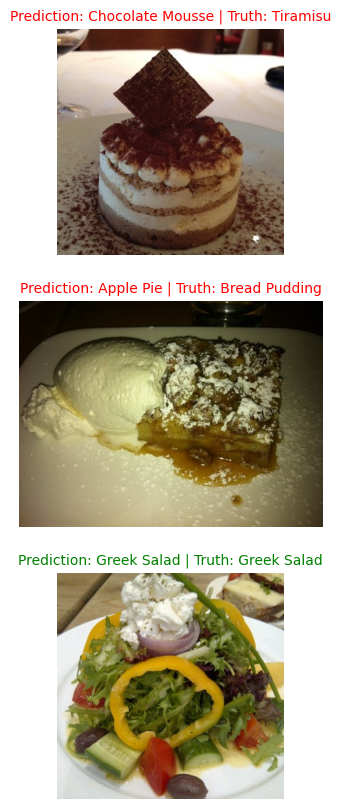

In [23]:
pred_and_plot(paths=test_data_paths,
              model=loaded_model,
              transform=auto_transforms,
              class_names=class_names)

In [30]:
test_paths = random.sample(test_data_paths, k=10)

loaded_model_preds = pred_and_store(paths=test_paths,
                                    model=loaded_model,
                                    transform=auto_transforms,
                                    class_names=class_names,
                                    device="cpu")

loaded_model_preds[:2]

  0%|          | 0/10 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/food-101/images/chocolate_cake/2868636.jpg'),
  'class_name': 'chocolate_cake',
  'pred_prob': 0.3964,
  'pred_class': 'chocolate_cake',
  'time_for_pred (s)': 0.163,
  'correct': True},
 {'image_path': PosixPath('data/food-101/images/nachos/111242.jpg'),
  'class_name': 'nachos',
  'pred_prob': 0.6408,
  'pred_class': 'nachos',
  'time_for_pred (s)': 0.1513,
  'correct': True}]

In [31]:
loaded_model_pred_df = pd.DataFrame(loaded_model_preds)
loaded_model_pred_df

,image_path,class_name,pred_prob,pred_class,time_for_pred (s),correct
0,data/food-101/images/chocolate_cake/2868636.jpg,chocolate_cake,0.3964,chocolate_cake,0.1630,True
1,data/food-101/images/nachos/111242.jpg,nachos,0.6408,nachos,0.1513,True
2,data/food-101/images/beet_salad/565113.jpg,beet_salad,0.4775,bibimbap,0.1545,False
3,data/food-101/images/pancakes/430115.jpg,pancakes,0.3029,club_sandwich,0.1430,False
4,data/food-101/images/hot_dog/1440436.jpg,hot_dog,0.2284,hot_dog,0.1521,True
5,data/food-101/images/hot_dog/1382254.jpg,hot_dog,0.3113,hot_dog,0.1466,True
6,data/food-101/images/samosa/848468.jpg,samosa,0.3713,samosa,0.1490,True
7,data/food-101/images/pulled_pork_sandwich/1980...,pulled_pork_sandwich,0.2401,breakfast_burrito,0.1406,False
8,data/food-101/images/cheese_plate/598262.jpg,cheese_plate,0.4694,cheese_plate,0.1396,True
9,data/food-101/images/fish_and_chips/3241574.jpg,fish_and_chips,0.9426,fish_and_chips,0.1419,True


In [32]:
loaded_model_pred_df.correct.value_counts()

True     7
False    3
Name: correct, dtype: int64

## Demo & Deploy

In [33]:
print(f"Gradio version: {gr.__version__}")

Gradio version: 3.48.0


In [34]:
loaded_model.to("cpu")
next(iter(loaded_model.parameters())).device

device(type='cpu')

In [37]:
def predict(img) -> Tuple[Dict, float]:
  """Transforms and performs a prediction on img and returns prediction and time taken.
  """
  start_time = timer()

  img = auto_transforms(img).unsqueeze(0)

  loaded_model.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(loaded_model(img), dim=1)
    # print(pred_probs)

  pred_labels_and_probs = {class_names[i].title().replace("_", " "): float(pred_probs[0][i]) for i in range(len(class_names))}

  pred_time = round(timer() - start_time, 2)

  return pred_labels_and_probs, pred_time

In [38]:
random_image_path = random.sample(test_data_paths, k=1)[0]

image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/food-101/images/spaghetti_bolognese/3298009.jpg

Prediction label and probability dictionary: 
{'Apple Pie': 0.00021037650003563613, 'Baby Back Ribs': 8.258477464551106e-06, 'Baklava': 0.00025725632440298796, 'Beef Carpaccio': 7.563318649772555e-05, 'Beef Tartare': 0.0001703964953776449, 'Beet Salad': 4.862377863901202e-06, 'Beignets': 0.00015287358837667853, 'Bibimbap': 0.0010258168913424015, 'Bread Pudding': 0.00015588101814500988, 'Breakfast Burrito': 0.00013792472600471228, 'Bruschetta': 0.00013573875185102224, 'Caesar Salad': 7.301894220290706e-05, 'Cannoli': 2.5311870558653027e-05, 'Caprese Salad': 3.8737965951440856e-05, 'Carrot Cake': 0.00022006744984537363, 'Ceviche': 3.9649461541557685e-05, 'Cheese Plate': 3.6577880564436782e-06, 'Cheesecake': 2.717111237870995e-05, 'Chicken Curry': 0.0003410610952414572, 'Chicken Quesadilla': 3.679064320749603e-05, 'Chicken Wings': 7.196113983809482e-06, 'Chocolate Cake': 2.785093329293886e-06, 'Choco

In [42]:
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=5)]
example_list

[['data/food-101/images/fried_calamari/1975481.jpg'],
 ['data/food-101/images/club_sandwich/3867527.jpg'],
 ['data/food-101/images/seaweed_salad/1479513.jpg'],
 ['data/food-101/images/pho/3805789.jpg'],
 ['data/food-101/images/ravioli/323909.jpg']]

In [47]:
title = "FoodVision 101"
description = f"CV model classifying 101 classes of food using food101 and EfficientNetB2 feature extractor."
article = "© Amuni Pelumi https://www.amunipelumi.com/"

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=1, label="Predicted Food"),
                             gr.Number(label="Prediction Duration (S)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

demo.launch(debug=False, share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://e9b74df0927a624c4d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [50]:
foodvision_101_path = Path("demos/foodvision_101/")

if foodvision_101_path.exists():
  shutil.rmtree(foodvision_101_path)
  foodvision_101_path.mkdir(parents=True, exist_ok=True)
else:
  foodvision_101_path.mkdir(parents=True, exist_ok=True)

In [52]:
foodvision_101_examples_path = foodvision_101_path/"examples"
foodvision_101_examples_path.mkdir(parents=True, exist_ok=True)

foodvision_101_examples = [Path('data/food-101/images/fried_calamari/1975481.jpg'),
                           Path('data/food-101/images/club_sandwich/3867527.jpg'),
                           Path('data/food-101/images/seaweed_salad/1479513.jpg'),
                           Path('data/food-101/images/pho/3805789.jpg'),
                           Path('data/food-101/images/ravioli/323909.jpg')]

for example in foodvision_101_examples:
  destination = foodvision_101_examples_path / example.name
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src=example, dst=destination)

[INFO] Copying data/food-101/images/fried_calamari/1975481.jpg to demos/foodvision_101/examples/1975481.jpg
[INFO] Copying data/food-101/images/club_sandwich/3867527.jpg to demos/foodvision_101/examples/3867527.jpg
[INFO] Copying data/food-101/images/seaweed_salad/1479513.jpg to demos/foodvision_101/examples/1479513.jpg
[INFO] Copying data/food-101/images/pho/3805789.jpg to demos/foodvision_101/examples/3805789.jpg
[INFO] Copying data/food-101/images/ravioli/323909.jpg to demos/foodvision_101/examples/323909.jpg


In [53]:
example_list = [["examples/" + example] for example in os.listdir(foodvision_101_examples_path)]
example_list

[['examples/3867527.jpg'],
 ['examples/323909.jpg'],
 ['examples/1479513.jpg'],
 ['examples/3805789.jpg'],
 ['examples/1975481.jpg']]

In [54]:
saved_model_path = "drive/MyDrive/Colab Notebooks/PyTorch/Models/effnetb2_feature_extractor_food101.pth"

destination = foodvision_101_path / saved_model_path.split("/")[5]

try:
  print(f"[INFO] Attempting to copy {saved_model_path} to {destination}")
  shutil.copy2(src=saved_model_path, dst=destination)
  print(f"[INFO] Model copy complete.")

except:
    print(f"[INFO] No model found at {saved_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {destination}: {destination.exists()}")

[INFO] Attempting to copy drive/MyDrive/Colab Notebooks/PyTorch/Models/effnetb2_feature_extractor_food101.pth to demos/foodvision_101/effnetb2_feature_extractor_food101.pth
[INFO] Model copy complete.


In [56]:
%%writefile demos/foodvision_101/model.py
import torch
import torchvision

from torch import nn


def create_model(num_classes:int=101, seed:int=13):

  """Creates an EfficientNetB2 feature extractor model and transforms.

  Args:
      num_classes (int, optional): number of classes in the classifier head.
          Defaults to 101.
      seed (int, optional): random seed value. Defaults to 42.

  Returns:
      model (torch.nn.Module): EffNetB2 feature extractor model.
      transforms (torchvision.transforms): EffNetB2 image transforms.
  """

  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes)
  )

  return model, transforms

Overwriting demos/foodvision_101/model.py


In [57]:
foodvision_101_class_names_path = foodvision_101_path / "class_names.txt"

with open(foodvision_101_class_names_path, "w") as f:
  print(f"[INFO] Saving food101 class names to {foodvision_101_class_names_path}")
  f.write("\n".join(class_names))

[INFO] Saving food101 class names to demos/foodvision_101/class_names.txt


In [59]:
with open(foodvision_101_class_names_path, "r") as f:
  food101_class_names = [i.strip() for i in  f.readlines()]

food101_class_names[:5], len(food101_class_names)

(['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare'],
 101)

In [60]:
%%writefile demos/foodvision_101/app.py
import gradio as gr
import os
import torch

from model import create_model
from timeit import default_timer as timer
from typing import Tuple, Dict

with open(foodvision_101_class_names_path, "r") as f:
  class_names = [i.strip() for i in  f.readlines()]

model, auto_transforms = create_model(len(class_names))

model.load_state_dict(
    torch.load(
        f="effnetb2_feature_extractor_food101.pth",
        map_location=torch.device("cpu")
    )
)

def predict(img) -> Tuple[Dict, float]:
  """Transforms and performs a prediction on img and returns prediction and time taken.
  """

  start_time = timer()

  img = auto_transforms(img).unsqueeze(0)

  model.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(model(img), dim=1)

  pred_labels_and_probs = {class_names[i].title().replace("_", " "): float(pred_probs[0][i]) for i in range(len(class_names))}

  pred_time = round(timer() - start_time, 2)

  return pred_labels_and_probs, pred_time


title = "FoodVision 101"
description = f"CV model classifying 101 classes of food using food101 and EfficientNetB2 feature extractor."
article = "© Amuni Pelumi https://www.amunipelumi.com/"

example_list = [["examples/" + example] for example in os.listdir("examples")]

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=1, label="Predicted Food"),
                             gr.Number(label="Prediction Duration (S)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

demo.launch()

Writing demos/foodvision_101/app.py


In [61]:
print(torch.__version__)
print(torchvision.__version__)
print(gr.__version__)

2.0.1+cu118
0.15.2+cu118
3.48.0


In [62]:
%%writefile demos/foodvision_101/requirements.txt
torch==2.0.1
torchvision==0.15.2
gradio==3.48.0

Writing demos/foodvision_101/requirements.txt


In [65]:
!ls demos/foodvision_101

app.py		 effnetb2_feature_extractor_food101.pth  model.py
class_names.txt  examples				 requirements.txt


In [ ]:
shutil.copytree(src="modular/", dst="demos/foodvision_101/modular/")
shutil.copy2(src="drive/MyDrive/Colab Notebooks/foodvision101.ipynb", dst="demos/foodvision_101/foodvision101.ipynb")

In [ ]:
!cd demos/foodvision_101 && zip -r foodvision-101.zip * -x "*.pyc" "*__pycache__*" "*ipynb_checkpoints*"